# Benchmark for the emission test tracer

The emission test tracer is transported in ICON-AES. The emission test tracer tendency is updated using Python code and the established bridges given in the field attribute `echam_ttr_config%icon_ml_bridge`. 

- `fortran`: Pure Fortran
- `cffi`
- `pipes`
- `mpi`

The benchmark is done on a one-month atm amip simulation where no output is written beyond the basic necessities.

## Read the times directly from log files

Keep the human out of the loop to avoid errors.

Cycle all the log files, check if they finished successfully, and retrieve the wall time

We go the lazy route and just load the full file, worst case the jupyterhub crashes 

In [1]:
import pandas as pd
import itertools
import os
from datetime import datetime
import numpy as np
import re

In [2]:
s = '    L echam'
m = re.match('\s+L interface_echam_ttr', s)
print(m)

None


In [3]:
refresh_frame = True # clear the dataframe --> False for speed up

if os.path.exists('./benchmark.csv') and not refresh_frame:
    df = pd.read_csv('./benchmark.csv')
else:
    df = pd.DataFrame(columns=['count', 'resolution', 'bridge', 'nodes', 'procs_pernode', 't_start', 't_end', 'logfile', 'is_logfile', 'is_finished_ok', 'tmax_total', 'tmax_echam_ttr'])
    df.t_start = df.t_start.astype(object)
    df = df.replace('nan', None)
df

,count,resolution,bridge,nodes,procs_pernode,t_start,t_end,logfile,is_logfile,is_finished_ok,tmax_total,tmax_echam_ttr


In [4]:
%%time

exp_dir = '/work/ka1176/caroline/jobs/hereon_iconml/one_month/R02B04_switch-1/'

var_nodes = [1, 2, 4, 8, 16, 32, 64]
var_procs_pernode = [128, 64, 32, 16]
var_counts = [1, 2, 3, 4, 5, 6, 7, 8, 9]
var_bridges = ['fortran', 'cffi', 'pipes', 'mpi']
var_resolutions = ['R02B04']

# regex patterns
# time stamp
pattern_stamp = '\w{3} \w{3} \d+ \d{2}:\d{2}:\d{2} \w{3,4} 202\d'
# in timer output
pattern_total = '\s*(0:)?\s+total\s+\d+'
pattern_ttr = '\s+(0:)?\s+L interface_echam_ttr\s+\d+'
# script finished OK
pattern_script_ok = '\+\s+finish_status=\'\s*OK\''

i=0
for nodes, procs_pernode, count, bridge, resolution in itertools.product(var_nodes, var_procs_pernode, var_counts, var_bridges, var_resolutions):
    
    # check if entry already exists in dataframe
    entry = df[df.eval(f"count=={count} & nodes=={nodes} & procs_pernode=={procs_pernode}")]
    entry = entry.loc[entry['bridge'] == bridge] # stupid string comparison does not work in eval
    entry = entry.loc[entry['resolution'] == resolution]
    
    assert len(entry) <= 1
    
    if len(entry) == 1 and entry['is_finished_ok'].all():
        # print(f'Entry exists, continue')
        continue
    
    logfile = f'LOG_exp.iconml_month_{bridge}_{nodes}-{procs_pernode}_{count}.run'
    is_logfile = os.path.exists(os.path.join(exp_dir, logfile))
    
    # none-initialize the values that are parsed from logfiles
    t_start = None
    t_end = None
    tmax_total = None
    tmax_echam_ttr = None
    is_finished_ok = False
    
    # check if the run finished OK
    if is_logfile:
        with open(os.path.join(exp_dir, logfile)) as f:
            line = f.readline()
            
            while line:
            
                # Start and end time stamps
                if re.match(pattern_stamp, line) is not None:
                    if t_start is None:
                        t_start = line.strip()
                    elif t_end is None:
                        t_end = line.strip()
                    else:
                        raise ValueError('Found more than 2 time stamps in log file')
                # total time (profiled)
                if re.match(pattern_total, line) is not None:
                    tmax_total = float(line.split()[-2])
                # time in echam_ttr (profiled)
                if re.match(pattern_ttr, line) is not None:
                    tmax_echam_ttr = float(line.split()[-2])       
                # script finished OK
                if re.match(pattern_script_ok, line) is not None:
                    is_finished_ok = True
                    
                # advance
                line = f.readline()
                                
    new_entry = pd.DataFrame(dict(count=count,
                               resolution=resolution,
                               bridge=bridge,
                               nodes=nodes,
                               procs_pernode=procs_pernode,
                               t_start=t_start,
                               t_end=t_end,
                               logfile=logfile,
                               is_logfile=is_logfile,
                               tmax_total=tmax_total,
                               tmax_echam_ttr=tmax_echam_ttr,
                               is_finished_ok=is_finished_ok), index=[i])
    
    df = pd.concat([df, new_entry], axis=0)
    
    i += 1
        
print(f'Added {i} new entries to dataframe')

Added 1008 new entries to dataframe
CPU times: user 2min 20s, sys: 59.3 s, total: 3min 19s
Wall time: 3min 42s


In [5]:
unfinished_df = df.loc[df['is_finished_ok'] == False]

In [6]:
df = df.loc[df['is_finished_ok']]

In [7]:
df.to_csv('./benchmark.csv')

## Process

- Calculate wall time
- Calculate total number of MPI cores

In [8]:
df['MPI_processes'] = df['nodes'] * df['procs_pernode']

In [9]:
def time_stamp_to_seconds(s, tsformat='%a %b %d %H:%M:%S %Z %Y', to_sec=True):
    '''
    Converts a time stamp from an ICON log script to UNIX seconds
    
    Parameters:
    
    s - Time stamp string
    tsformat - Format see https://strftime.org/
    to_sec - Return as Epoch seconds (default: True)
    
    Returns:
    Parsed time stamp in requested format
    '''
    
    if s == 'None': # typecast as str
        return None
        
    x = datetime.strptime(s, tsformat)
    
    if to_sec:
        return int(x.strftime('%s'))
    return x

In [10]:
df_sec = df[['t_start', 't_end']].astype(str).applymap(time_stamp_to_seconds)
df_sec

,t_start,t_end
0,1655200776,1655202387
1,1655205451,1655207055
2,1661328065,1661330031
4,1655200776,1655202386
5,1655205451,1655207035
...,...,...
817,1655290510,1655290816
820,1655289637,1655289937
821,1655290787,1655291083
824,1655289704,1655290001


In [11]:
df['delta_t'] = df_sec['t_end'] - df_sec['t_start']
df['node_hours'] = df['delta_t'] * df['nodes'] / 3600

## Plot

In [12]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_style('whitegrid')
sns.set_context('talk')

### For different numbers of mpi_procs

32


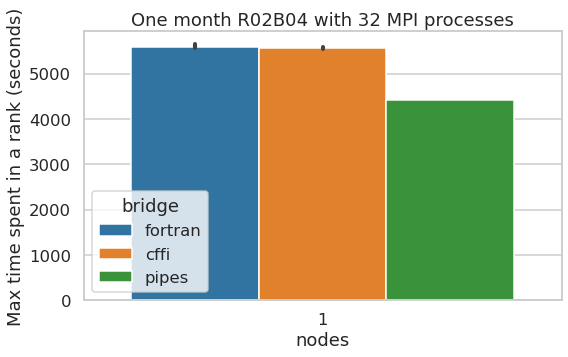

64


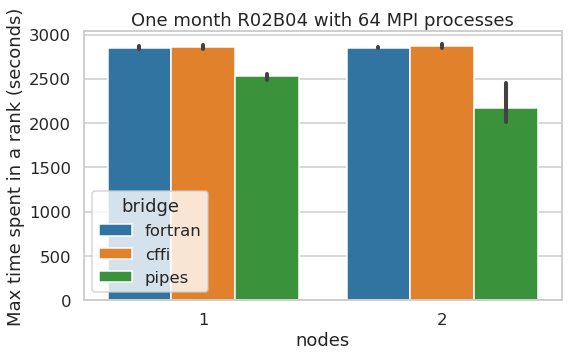

128


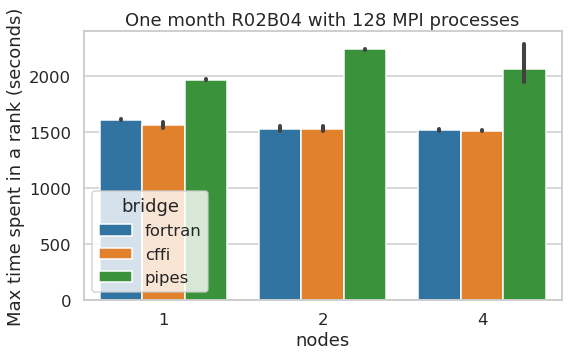

256


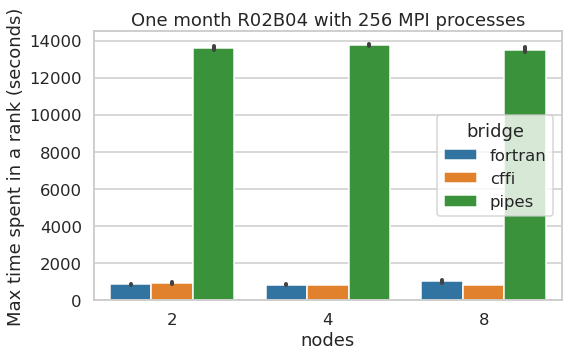

512


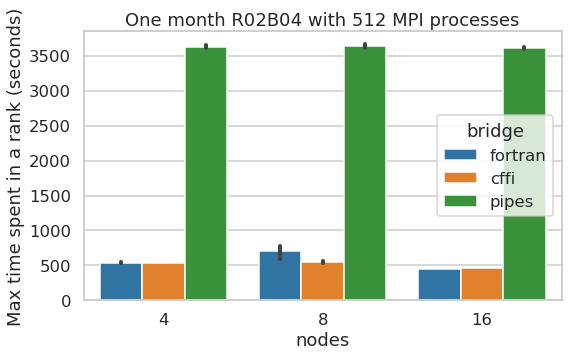

1024


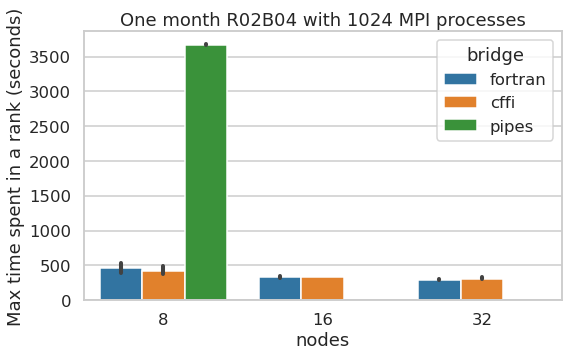

2048


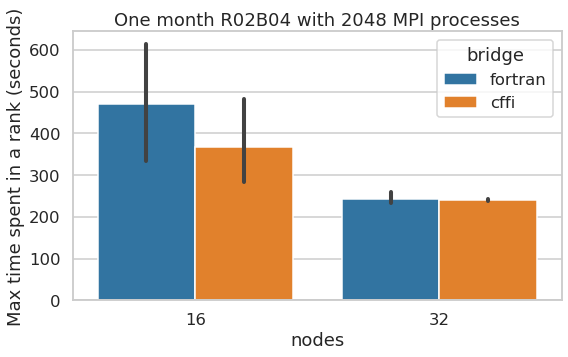

4096


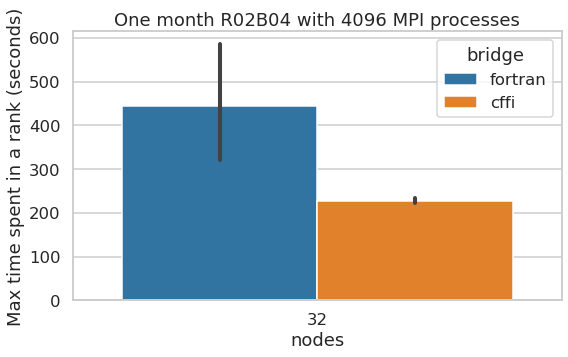

In [13]:
for procs in np.sort(pd.unique(df.MPI_processes)):
    print(procs)
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))

    sns.barplot(data=df.loc[df['MPI_processes'] == procs], x='nodes', y='delta_t', hue='bridge', ax=ax)

    ax.set_title(f'One month R02B04 with {procs} MPI processes')
    ax.set_ylabel('Max time spent in a rank (seconds)')

    fig.tight_layout()
    plt.show()

32


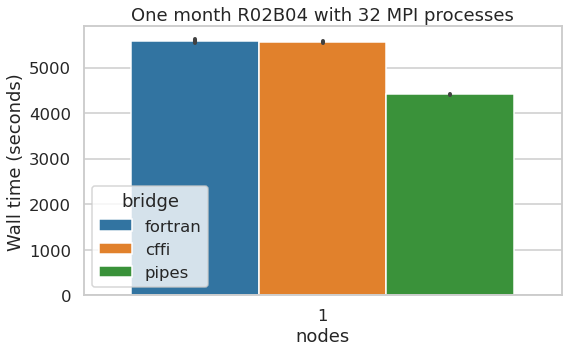

64


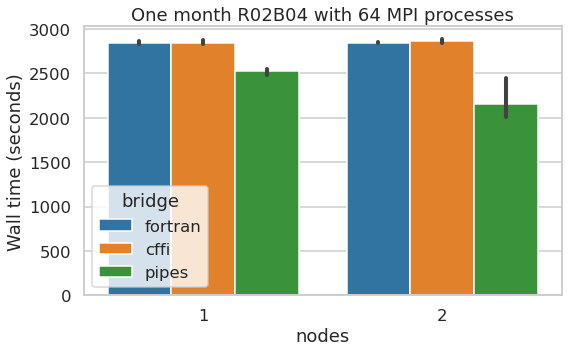

128


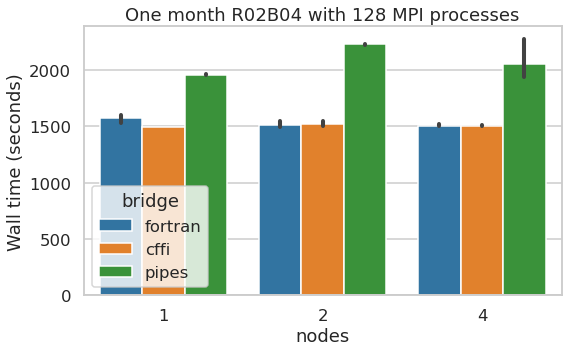

256


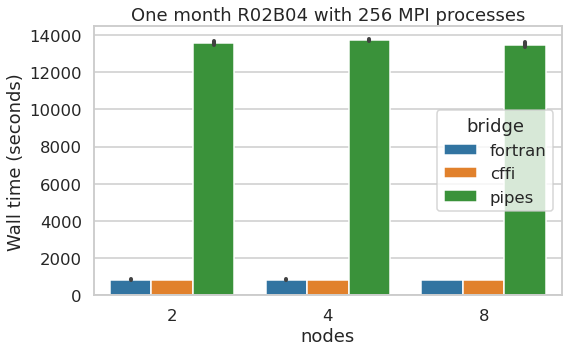

512


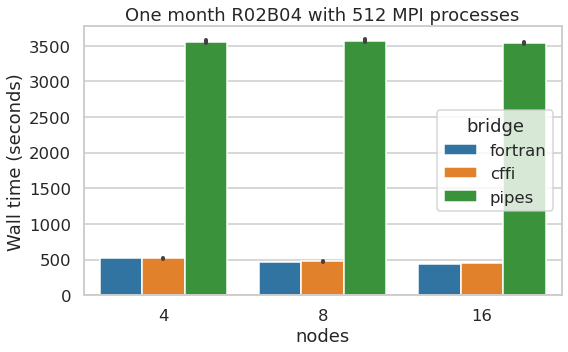

1024


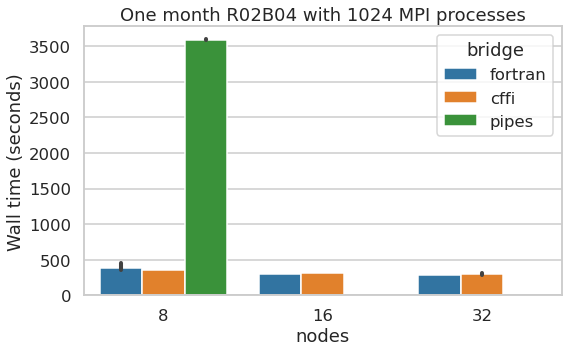

2048


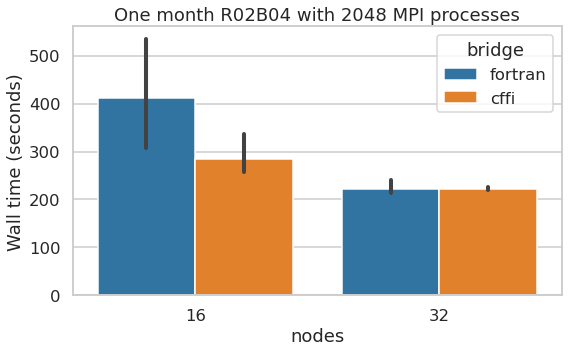

4096


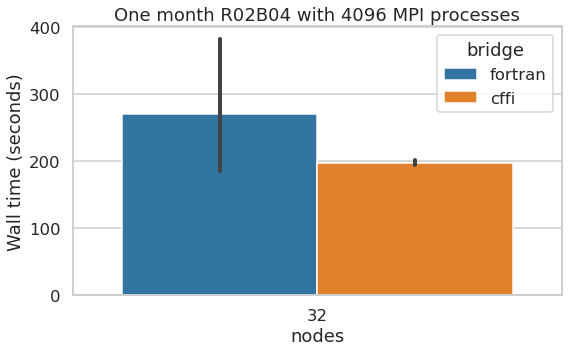

In [14]:
for procs in np.sort(pd.unique(df.MPI_processes)):
    print(procs)
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))

    sns.barplot(data=df.loc[df['MPI_processes'] == procs], x='nodes', y='tmax_total', hue='bridge', ax=ax)

    ax.set_title(f'One month R02B04 with {procs} MPI processes')
    ax.set_ylabel('Wall time (seconds)')

    fig.tight_layout()
    plt.show()

### Bridge scaling compared

In [15]:
df.groupby(['MPI_processes', 'bridge'])['delta_t'].mean()

MPI_processes  bridge 
32             cffi        5570.200000
               fortran     5588.600000
               pipes       4414.000000
64             cffi        2860.800000
               fortran     2852.100000
               pipes       2392.875000
128            cffi        1535.933333
               fortran     1550.533333
               pipes       2091.444444
256            cffi         855.666667
               fortran      908.266667
               pipes      13632.000000
512            cffi         518.800000
               fortran      607.000000
               pipes       3626.000000
1024           cffi         356.259259
               fortran      362.814815
               pipes       3670.500000
2048           cffi         303.555556
               fortran      356.277778
4096           cffi         228.000000
               fortran      443.875000
Name: delta_t, dtype: float64

In [16]:
xtix = np.sort(pd.unique(df.MPI_processes)).astype(int)
print(xtix)

perfect_scale = [4140] * len(xtix) # perfect scale if 32 is the fixed value
perfect_scale = np.array(perfect_scale) * 32 / xtix

[  32   64  128  256  512 1024 2048 4096]


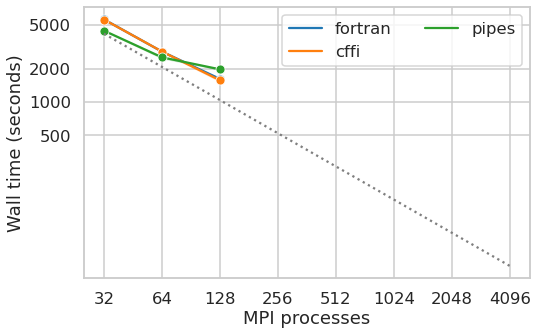

In [17]:
fig = plt.figure(figsize=(8, 5))

sns.lineplot(data=df.loc[df['nodes'] == 1], x='MPI_processes', y='delta_t', hue='bridge', legend='brief', marker='o')
ax=plt.gca()
ax.set(xscale="log", yscale="log")
ax.set_xlabel('MPI processes')
ax.set_ylabel('Wall time (seconds)')

ax.set_xticks(xtix)
ax.set_xticklabels(xtix)

ax.set_yticks([500, 1000, 2000, 5000])
ax.set_yticklabels([500, 1000, 2000, 5000])


ax.plot(xtix, perfect_scale, ':', color='C7')
ax.legend(ncol=2)

plt.show()


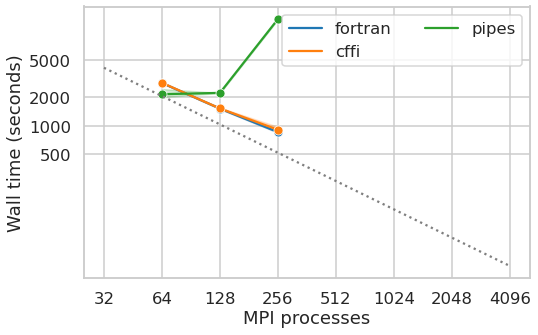

In [18]:
fig = plt.figure(figsize=(8, 5))

sns.lineplot(data=df.loc[df['nodes'] == 2], x='MPI_processes', y='delta_t', hue='bridge', legend='brief', marker='o')
ax=plt.gca()
ax.set(xscale="log", yscale="log")
ax.set_xlabel('MPI processes')
ax.set_ylabel('Wall time (seconds)')

ax.set_xticks(xtix)
ax.set_xticklabels(xtix)

ax.set_yticks([500, 1000, 2000, 5000])
ax.set_yticklabels([500, 1000, 2000, 5000])


ax.plot(xtix, perfect_scale, ':', color='C7')
ax.legend(ncol=2)

plt.show()


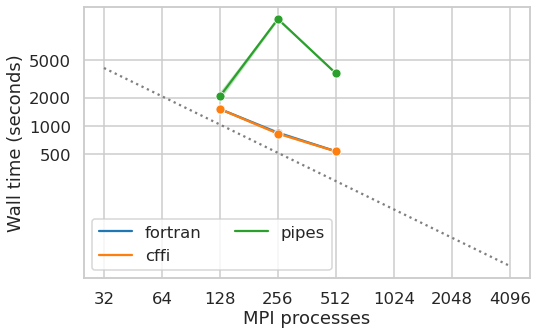

In [19]:
fig = plt.figure(figsize=(8, 5))

sns.lineplot(data=df.loc[df['nodes'] == 4], x='MPI_processes', y='delta_t', hue='bridge', legend='brief', marker='o')
ax=plt.gca()
ax.set(xscale="log", yscale="log")
ax.set_xlabel('MPI processes')
ax.set_ylabel('Wall time (seconds)')

ax.set_xticks(xtix)
ax.set_xticklabels(xtix)

ax.set_yticks([500, 1000, 2000, 5000])
ax.set_yticklabels([500, 1000, 2000, 5000])


ax.plot(xtix, perfect_scale, ':', color='C7')
ax.legend(ncol=2)

plt.show()


Compare the runtime when bridge is included with the original Fortran runtime

In [20]:
for procs in np.sort(pd.unique(df.MPI_processes)):
    print('-'*40)
    print(' MPI processes: ', procs)
    
    tmp = df.loc[(df['MPI_processes']==procs) & (df['bridge'] != 'mpi')].groupby('bridge')['delta_t'].mean()
    
    if tmp.isnull().all():
        continue

    tmp =  100 * (tmp - tmp.fortran) / tmp.fortran
    
    print('Relative increase (%) compared to FORTRAN runtime\n', tmp)

----------------------------------------
 MPI processes:  32
Relative increase (%) compared to FORTRAN runtime
 bridge
cffi       -0.329242
fortran     0.000000
pipes     -21.017786
Name: delta_t, dtype: float64
----------------------------------------
 MPI processes:  64
Relative increase (%) compared to FORTRAN runtime
 bridge
cffi        0.305038
fortran     0.000000
pipes     -16.101294
Name: delta_t, dtype: float64
----------------------------------------
 MPI processes:  128
Relative increase (%) compared to FORTRAN runtime
 bridge
cffi       -0.941611
fortran     0.000000
pipes      34.885487
Name: delta_t, dtype: float64
----------------------------------------
 MPI processes:  256
Relative increase (%) compared to FORTRAN runtime
 bridge
cffi         -5.791251
fortran       0.000000
pipes      1400.880799
Name: delta_t, dtype: float64
----------------------------------------
 MPI processes:  512
Relative increase (%) compared to FORTRAN runtime
 bridge
cffi       -14.530478
fo

### Node hours

In [21]:
df['delta_t_hrs'] = df['delta_t'] / 3600

In [22]:
for bridge in var_bridges:
    print('**', bridge)
    min_node_hours = df.loc[df['bridge'] == bridge].sort_values('delta_t').iloc[0]
    print(min_node_hours.loc[['delta_t_hrs', 'node_hours', 'nodes', 'procs_pernode']])

** fortran
delta_t_hrs      0.063611
node_hours       2.035556
nodes                  32
procs_pernode          64
Name: 764, dtype: object
** cffi
delta_t_hrs      0.060556
node_hours       1.937778
nodes                  32
procs_pernode         128
Name: 753, dtype: object
** pipes
delta_t_hrs      0.540556
node_hours       2.162222
nodes                   4
procs_pernode          32
Name: 370, dtype: object
** mpi


IndexError: single positional indexer is out-of-bounds

In [ ]:

sns.scatterplot(data=df, x='node_hours', y='delta_t_hrs', hue='bridge')
ax=plt.gca()
ax.set_xlabel('Node hours')
ax.set_ylabel('Wall time (hours)')
ax.legend(ncol=2, loc=2)
xx = np.linspace(0.3, 2.0)
ax.plot(xx, xx, ':', color='C7')
ax.plot(xx, xx/2, ':', color='C7')
ax.plot(xx, xx/4, ':', color='C7')
plt.show()

## Profiler

In [23]:
df['frac_ttr_total'] = df['tmax_echam_ttr'] / df['tmax_total']

In [24]:
df

,count,resolution,bridge,nodes,procs_pernode,t_start,t_end,logfile,is_logfile,is_finished_ok,tmax_total,tmax_echam_ttr,MPI_processes,delta_t,node_hours,delta_t_hrs,frac_ttr_total
0,1,R02B04,fortran,1,128,Tue Jun 14 11:59:36 CEST 2022,Tue Jun 14 12:26:27 CEST 2022,LOG_exp.iconml_month_fortran_1-128_1.run,True,True,1487.274,0.258,128,1611,0.4475,0.447500,0.000173
1,1,R02B04,cffi,1,128,Tue Jun 14 13:17:31 CEST 2022,Tue Jun 14 13:44:15 CEST 2022,LOG_exp.iconml_month_cffi_1-128_1.run,True,True,1495.312,7.22,128,1604,0.445556,0.445556,0.004828
2,1,R02B04,pipes,1,128,Wed Aug 24 10:01:05 CEST 2022,Wed Aug 24 10:33:51 CEST 2022,LOG_exp.iconml_month_pipes_1-128_1.run,True,True,1956.917,514.649,128,1966,0.546111,0.546111,0.26299
4,2,R02B04,fortran,1,128,Tue Jun 14 11:59:36 CEST 2022,Tue Jun 14 12:26:26 CEST 2022,LOG_exp.iconml_month_fortran_1-128_2.run,True,True,1597.167,0.275,128,1610,0.447222,0.447222,0.000172
5,2,R02B04,cffi,1,128,Tue Jun 14 13:17:31 CEST 2022,Tue Jun 14 13:43:55 CEST 2022,LOG_exp.iconml_month_cffi_1-128_2.run,True,True,1493.572,5.439,128,1584,0.44,0.440000,0.003642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
817,7,R02B04,cffi,32,32,Wed Jun 15 12:55:10 CEST 2022,Wed Jun 15 13:00:16 CEST 2022,LOG_exp.iconml_month_cffi_32-32_7.run,True,True,292.822,5.586,1024,306,2.72,0.085000,0.019076
820,8,R02B04,fortran,32,32,Wed Jun 15 12:40:37 CEST 2022,Wed Jun 15 12:45:37 CEST 2022,LOG_exp.iconml_month_fortran_32-32_8.run,True,True,289.451,0.102,1024,300,2.666667,0.083333,0.000352
821,8,R02B04,cffi,32,32,Wed Jun 15 12:59:47 CEST 2022,Wed Jun 15 13:04:43 CEST 2022,LOG_exp.iconml_month_cffi_32-32_8.run,True,True,285.611,5.113,1024,296,2.631111,0.082222,0.017902
824,9,R02B04,fortran,32,32,Wed Jun 15 12:41:44 CEST 2022,Wed Jun 15 12:46:41 CEST 2022,LOG_exp.iconml_month_fortran_32-32_9.run,True,True,283.837,0.093,1024,297,2.64,0.082500,0.000328


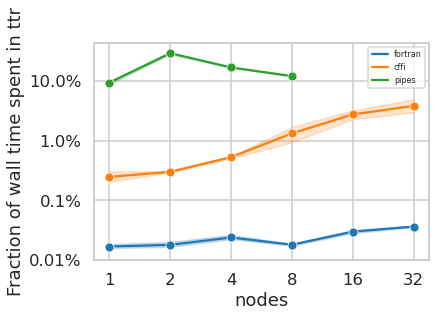

In [25]:
sns.lineplot(data=df.loc[df.procs_pernode==64], x='nodes', y='frac_ttr_total', hue='bridge', marker='o')
ax=plt.gca()

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xticks([1, 2, 4, 8, 16, 32])
ax.set_xticklabels([1, 2, 4, 8, 16, 32])

ax.set_yticks([1e-4, 1e-3, 1e-2, 1e-1])
ax.set_yticklabels(['0.01%', '0.1%', '1.0%', '10.0%'])

ax.set_ylabel('Fraction of wall time spent in ttr')

ax.legend(fontsize=8)

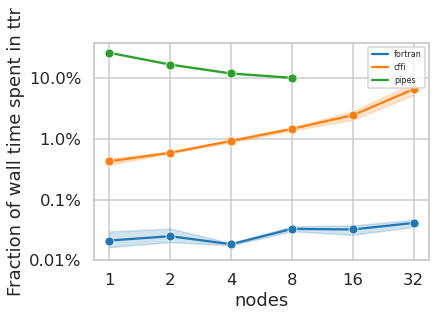

In [26]:
sns.lineplot(data=df.loc[df.procs_pernode==128], x='nodes', y='frac_ttr_total', hue='bridge', marker='o')
ax=plt.gca()

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xticks([1, 2, 4, 8, 16, 32])
ax.set_xticklabels([1, 2, 4, 8, 16, 32])

ax.set_yticks([1e-4, 1e-3, 1e-2, 1e-1])
ax.set_yticklabels(['0.01%', '0.1%', '1.0%', '10.0%'])

ax.set_ylabel('Fraction of wall time spent in ttr')

ax.legend(fontsize=8)

In [27]:
np.sort(pd.unique(df.MPI_processes)).astype(float)

array([  32.,   64.,  128.,  256.,  512., 1024., 2048., 4096.])

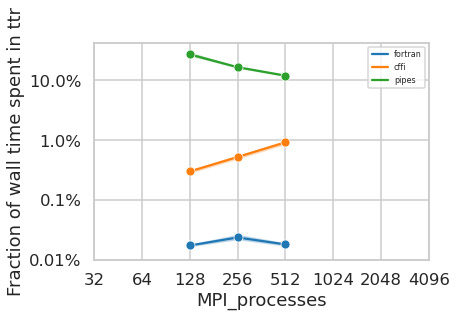

In [33]:
sns.lineplot(data=df.loc[df['nodes'] == 4], x='MPI_processes', y='frac_ttr_total', hue='bridge', marker='o')
ax=plt.gca()

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xticks(np.sort(pd.unique(df.MPI_processes)).astype(int))
ax.set_xticklabels(np.sort(pd.unique(df.MPI_processes)).astype(int))

ax.set_yticks([1e-4, 1e-3, 1e-2, 1e-1])
ax.set_yticklabels(['0.01%', '0.1%', '1.0%', '10.0%'])

ax.set_ylabel('Fraction of wall time spent in ttr')

ax.legend(fontsize=8)

<AxesSubplot:xlabel='nodes', ylabel='frac_total_walltime'>

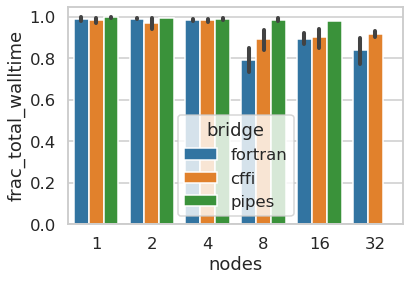

In [29]:
df['frac_total_walltime'] = df['tmax_total'] / df['delta_t']

sns.barplot(data=df, x='nodes', y='frac_total_walltime', hue='bridge')

In [30]:
unfinished_df[unfinished_df.t_start.isna()]

,count,resolution,bridge,nodes,procs_pernode,t_start,t_end,logfile,is_logfile,is_finished_ok,tmax_total,tmax_echam_ttr
3,1,R02B04,mpi,1,128,None,None,LOG_exp.iconml_month_mpi_1-128_1.run,False,False,None,None
7,2,R02B04,mpi,1,128,None,None,LOG_exp.iconml_month_mpi_1-128_2.run,False,False,None,None
11,3,R02B04,mpi,1,128,None,None,LOG_exp.iconml_month_mpi_1-128_3.run,False,False,None,None
14,4,R02B04,pipes,1,128,None,None,LOG_exp.iconml_month_pipes_1-128_4.run,False,False,None,None
15,4,R02B04,mpi,1,128,None,None,LOG_exp.iconml_month_mpi_1-128_4.run,False,False,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...
1003,8,R02B04,mpi,64,16,None,None,LOG_exp.iconml_month_mpi_64-16_8.run,False,False,None,None
1004,9,R02B04,fortran,64,16,None,None,LOG_exp.iconml_month_fortran_64-16_9.run,False,False,None,None
1005,9,R02B04,cffi,64,16,None,None,LOG_exp.iconml_month_cffi_64-16_9.run,False,False,None,None
1006,9,R02B04,pipes,64,16,None,None,LOG_exp.iconml_month_pipes_64-16_9.run,False,False,None,None


In [31]:
unfinished_df.loc[unfinished_df['bridge'] == 'pipes']

,count,resolution,bridge,nodes,procs_pernode,t_start,t_end,logfile,is_logfile,is_finished_ok,tmax_total,tmax_echam_ttr
14,4,R02B04,pipes,1,128,None,None,LOG_exp.iconml_month_pipes_1-128_4.run,False,False,None,None
18,5,R02B04,pipes,1,128,None,None,LOG_exp.iconml_month_pipes_1-128_5.run,False,False,None,None
22,6,R02B04,pipes,1,128,None,None,LOG_exp.iconml_month_pipes_1-128_6.run,False,False,None,None
26,7,R02B04,pipes,1,128,None,None,LOG_exp.iconml_month_pipes_1-128_7.run,False,False,None,None
30,8,R02B04,pipes,1,128,None,None,LOG_exp.iconml_month_pipes_1-128_8.run,False,False,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...
990,5,R02B04,pipes,64,16,None,None,LOG_exp.iconml_month_pipes_64-16_5.run,False,False,None,None
994,6,R02B04,pipes,64,16,None,None,LOG_exp.iconml_month_pipes_64-16_6.run,False,False,None,None
998,7,R02B04,pipes,64,16,None,None,LOG_exp.iconml_month_pipes_64-16_7.run,False,False,None,None
1002,8,R02B04,pipes,64,16,None,None,LOG_exp.iconml_month_pipes_64-16_8.run,False,False,None,None
